In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 调用GPU加速
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Climate Data Time-Series
We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

| Index | Features        | Format              | Description                                                                                                                                                                                                        |
|-------|-----------------|---------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1     | Date Time       | 01.01.2009 00:10:00 | Date-time reference                                                                                                                                                                                                |
| 2     | p (mbar)        | 996.52              | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.                                                               |
| 3     | T (degC)        | -8.02               | Temperature in Celsius                                                                                                                                                                                             |
| 4     | Tpot (K)        | 265.4               | Temperature in Kelvin                                                                                                                                                                                              |
| 5     | Tdew (degC)     | -8.9                | Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses. |
| 6     | rh (%)          | 93.3                | Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.                                                           |
| 7     | VPmax (mbar)    | 3.33                | Saturation vapor pressure                                                                                                                                                                                          |
| 8     | VPact (mbar)    | 3.11                | Vapor pressure                                                                                                                                                                                                     |
| 9     | VPdef (mbar)    | 0.22                | Vapor pressure deficit                                                                                                                                                                                             |
| 10    | sh (g/kg)       | 1.94                | Specific humidity                                                                                                                                                                                                  |
| 11    | H2OC (mmol/mol) | 3.12                | Water vapor concentration                                                                                                                                                                                          |
| 12    | rho (g/m ** 3)  | 1307.75             | Airtight                                                                                                                                                                                                           |
| 13    | wv (m/s)        | 1.03                | Wind speed                                                                                                                                                                                                         |
| 14    | max. wv (m/s)   | 1.75                | Maximum wind speed                                                                                                                                                                                                 |
| 15    | wd (deg)        | 152.3               | Wind direction in degrees                                                                                                                                                                                          |

In [3]:
#（1）读取数据集
filepath = './data/jena_climate_2009_2016.csv'
df = pd.read_csv(filepath)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 2009 to 2016.
It also shows where anomalies are present, which will be addressed during normalization.

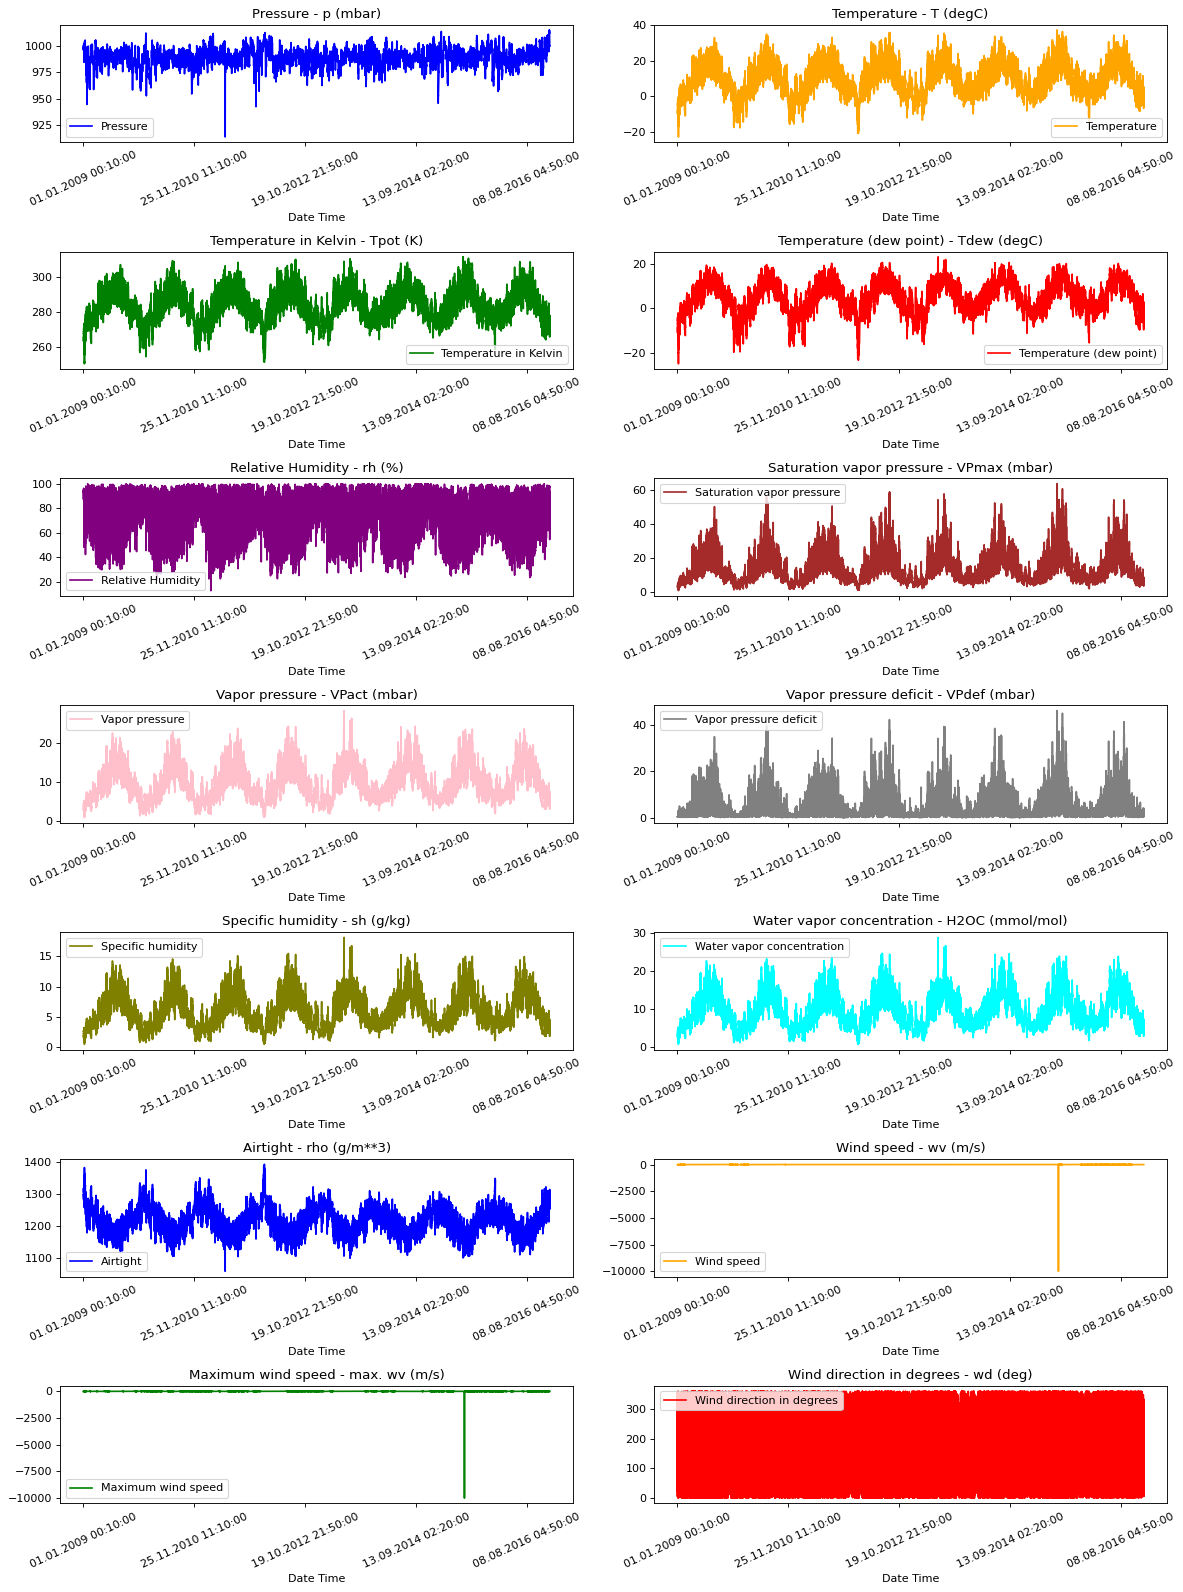

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Data Preprocessing

Here we are picking ~300,000 data points for training. Observation is recorded every
10 mins, that means 6 times per hour. We will resample one point per hour since no
drastic change is expected within 60 minutes. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 720 timestamps (720/6=120 hours). This data will be
used to predict the temperature after 72 timestamps (72/6=12 hours).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 300,693 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 5 days i.e. 720 observations, that are sampled every
hour. The temperature after 72 (12 hours * 6 observation per hour) observation will be
used as a label.

In [5]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 20


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [6]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [1, 2, 3, 4, 8, 9 ]]),
)
selected_features = [feature_keys[i] for i in [1, 2, 3, 4, 8, 9 ]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
print(len(train_data))
val_data = features.loc[train_split:]
print(len(val_data))
print(len(df))


The selected parameters are: Temperature, Temperature in Kelvin, Temperature (dew point), Relative Humidity, Specific humidity, Water vapor concentration
300693
119858
420551


# Training dataset

The training dataset labels starts from the 792nd observation (720 + 72).

In [7]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(len(selected_features))]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [8]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## Validation dataset

The validation dataset must not contain the last 792 rows as we won't have label data for
those records, hence 792 must be subtracted from the end of the data.

The validation label dataset must start from 792 after train_split, hence we must add
past + future (792) to label_start.

In [9]:
x_end = len(val_data) - past - future
print(x_end)
label_start = train_split + past + future
print(label_start)

x_val = val_data.iloc[:x_end][[i for i in range(len(selected_features))]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

119066
301485
Input shape: (256, 120, 6)
Target shape: (256, 1)


In [10]:
inputs = keras.Input(shape=(inputs.shape[1], inputs.shape[2]))
# #LSTM
# x = layers.LSTM(units=8, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
# x = layers.LeakyReLU()(x)
# x = layers.LSTM(units=16, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
# x = layers.LeakyReLU()(x)
# x = layers.LSTM(units=32, dropout=0.5, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = layers.LeakyReLU()(x)
# # Fully connector
# x = layers.Dense(64, kernel_initializer='random_normal',kernel_regularizer=keras.regularizers.l2(0.01))(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1)(x)


lstm_out = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(lstm_out)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 6)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4992      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [92]:
path_checkpoint = "./model/weather_LSTM2.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
1171/1172 [============================>.] - ETA: 0s - loss: 0.1978 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.15530, saving model to .\weather_LSTM2.h5
1172/1172 [==============================] - 47s 40ms/step - loss: 0.1977 - accuracy: 0.0000e+00 - val_loss: 0.1553 - val_accuracy: 0.0000e+00
Epoch 2/20
1171/1172 [============================>.] - ETA: 0s - loss: 0.1390 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 0.15530 to 0.15309, saving model to .\weather_LSTM2.h5
1172/1172 [==============================] - 61s 52ms/step - loss: 0.1389 - accuracy: 0.0000e+00 - val_loss: 0.1531 - val_accuracy: 0.0000e+00
Epoch 3/20
1171/1172 [============================>.] - ETA: 0s - loss: 0.1327 - accuracy: 0.0000e+00
Epoch 00003: val_loss improved from 0.15309 to 0.15140, saving model to .\weather_LSTM2.h5
1172/1172 [==============================] - 76s 65ms/step - loss: 0.1327 - accuracy: 0.0000e+00 - val_loss: 0.1514 - val_accuracy: 0.0000e

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

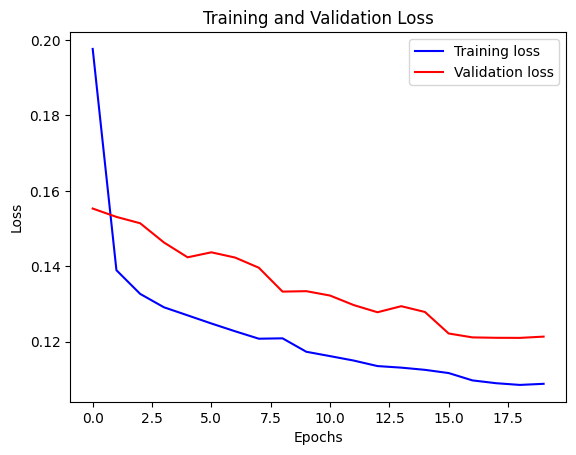

In [107]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [19]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

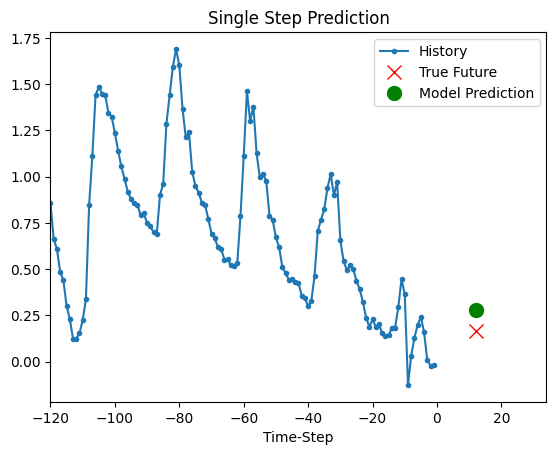

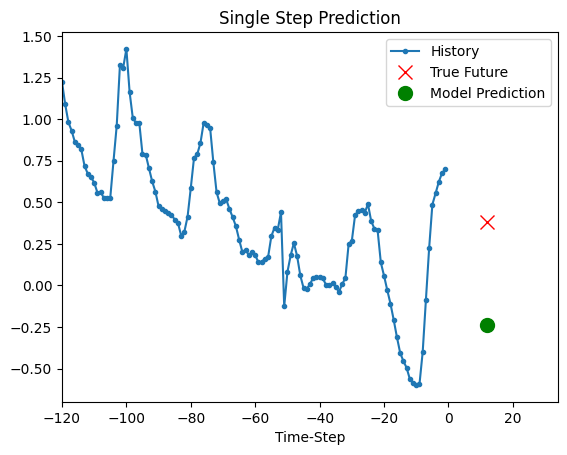

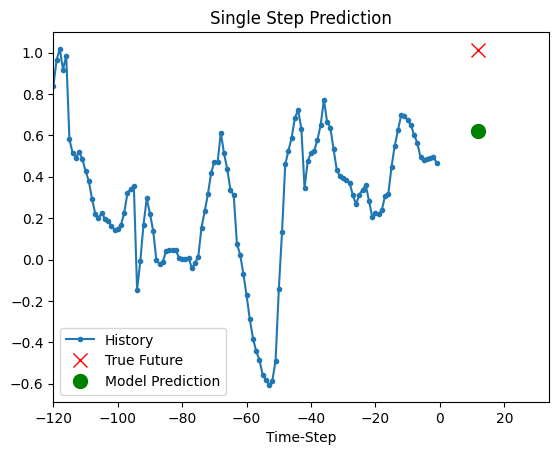

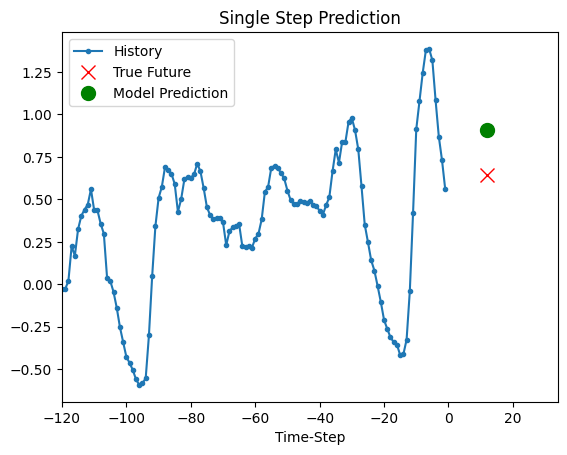

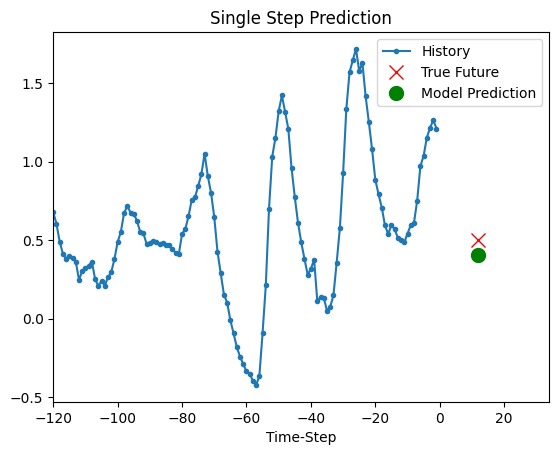

In [111]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [20]:
def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/step, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/step, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [26]:
# load the checkpoint
checkpoint = tf.keras.models.load_model('./model/weather_LSTM.h5')
checkpoint.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 120, 6)]          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                4992      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


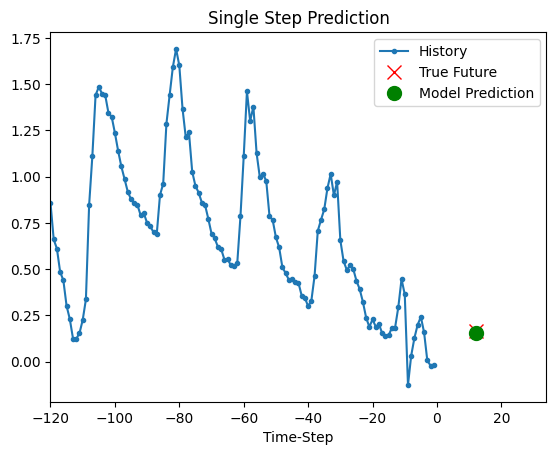

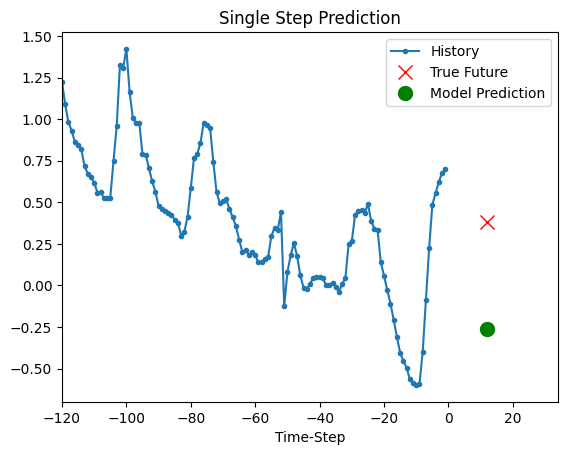

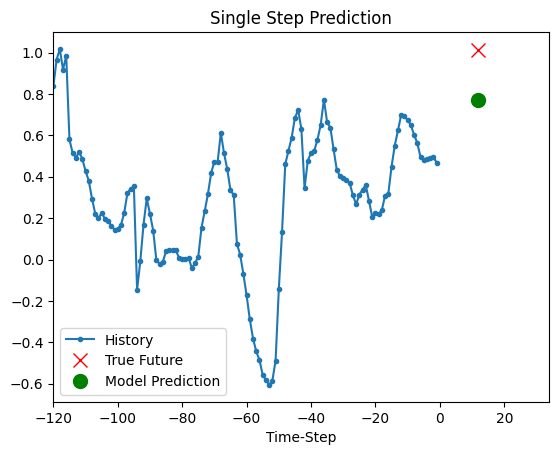

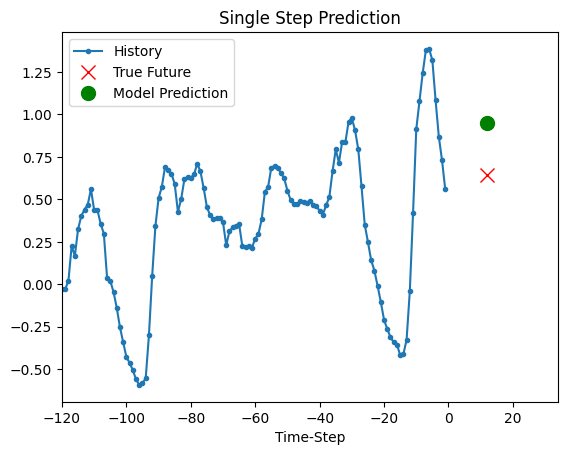

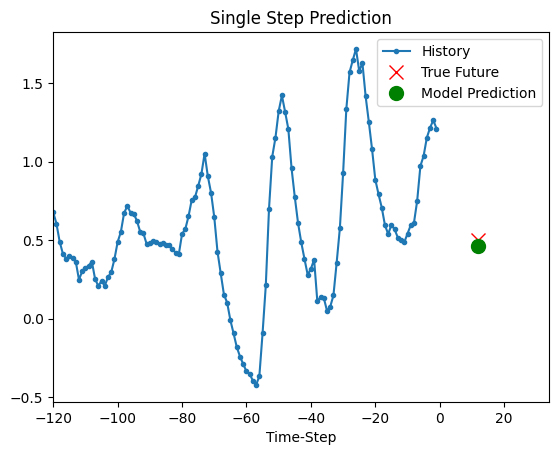

In [27]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), checkpoint.predict(x)[0]],
        12,
        "Single Step Prediction",
    )